In [ ]:
## Imports
import numpy as np
import torch
from PIL import Image
import cv2
from torch.nn import functional as F
import einops
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import image_grid, visualization_preprocess
from utils.models.prs_hook import hook_prs_logger    # Logger for applying hook to model
from matplotlib import pyplot as plt
from utils.scripts.algorithms_text_explanations_funcs import *
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
import timm

In [2]:
## Parameters
device = 'cpu'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 0
num_last_layers_ = 4
subset_dim = None
tot_samples_per_class = None
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "binary_waterbirds"
algorithm = "svd_data_approx"
path = './datasets/'

if model_name == "ViT-H-14":
    pretrained = "laion2B-s32B-b79K"
elif model_name == "ViT-L-14":
    pretrained = "laion2B-s32B-b82K"
elif model_name == "ViT-B-16":
    pretrained = "laion2B-s34B-b88K"
elif model_name == "ViT-B-32":
    pretrained = "laion2B-s34B-b79K"

In [ ]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained, cache_dir="../cache")
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=True) # This attach hook to get the residual stream

In [ ]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r"))  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r"))
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r"))
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])
# Get mean ablation
no_heads_attentions_ = attns_.sum(axis=(2))  # Sum over heads dimension
last_ = attns_.shape[1] - num_last_layers_
# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_mean_ablation_per_head_sum_ = torch.mean(no_heads_attentions_[:, :last_ + 1], axis=0).sum(0)

# Save important stuff
nr_layers_ = attns_.shape[1]
nr_heads_ = attns_.shape[2]

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

# Print metadata accuracy if waterbird
if classes_ == waterbird_classes:
    root = "datasets/waterbird_complete95_forest2water2/"
    df = pd.read_csv(root + "metadata.csv")
    filtered_df = df[df['split'] == 2]

    s = [(os.path.join(root, filtered_df.iloc[i]['img_filename']), filtered_df.iloc[i]['y'], filtered_df.iloc[i]['place']) for i in range(len(filtered_df))]
    background_groups_ = list([x[2] for x in s])

# Retrieve Rank
data = get_data(attention_dataset, skip_final=True)
mean_rank_ = 0
for entry in data:
    mean_rank_ += entry["rank"]
mean_rank_ /= len(data)

In [ ]:
## Load image
image_pil = Image.open('images/Black_Footed_Albatross_0047_796064.jpg')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [ ]:
## Run the image and compute attentions and mlps
prs.reinit()
with torch.no_grad():
    # Get the embedding of the image
    representation = model.encode_image(image.to(device), 
                                        attn_method='head', # get patch contribution per fixed head
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 12, 197, 16, 512], [b, l, n, h, d], mlps: [1, 13, 512], [b, l + 1, d]
    attentions = einops.rearrange(attentions, "b l n h d -> b l h n d")
    print(attentions.shape, mlps.shape)

## Visualize token decomposition on full output

In [18]:
## Get the texts
lines = ["waterbird", "land background"]
texts = tokenizer(lines).to(device)  # tokenize text for encoder
class_embeddings = model.encode_text(texts)

In [19]:
def plot_segment_map(attentions, class_embeddings, image_pil, lines, device, layer=None, head=None):
    """
    Generate and display zero-shot segmentation maps for an arbitrary number of text embeddings.
    
    Parameters:
        attentions (torch.Tensor): Attention maps from the model with shape [B, heads, tokens, tokens].
                                   (Assumed that the first token is the CLS token.)
        class_embeddings (torch.Tensor): Text embeddings for each class with shape [num_classes, embed_dim].
        image_pil (PIL.Image): The original image (as a PIL image) on which to overlay the segmentation maps.
        lines: class_names (list of strings)
        device: The torch device to perform interpolation on.
        layer: Optional; specifies a particular layer of attention to use.
        head: Optional; specifies a particular head to use if layer is specified.
    """
    
    # 1. Compose the attention map.
    #    Skip the first token (CLS), sum over heads and remaining tokens,
    #    then perform a dot product with the text embeddings (transposed) to get one score per patch per class.
    #    Shape: [num_patches, num_classes]
    if layer is None:
        pred = attentions[0, :, :, 1:].sum(axis=(0, 1)) / attentions[0, :, :, 1:].sum(axis=(0, 1)).norm(dim=-1, keepdim=True)
        attention_map = pred @ class_embeddings.T
    else:
        if head is None:
            pred = attentions[0, layer, :, 1:].sum(axis=0) / attentions[0, layer, :, 1:].sum(axis=0).norm(dim=-1, keepdim=True)
            attention_map = pred @ class_embeddings.T
        else:
            pred = attentions[0, layer, head, 1:] / attentions[0, layer, head, 1:].norm(dim=-1, keepdim=True)
            attention_map = pred @ class_embeddings.T

    # 2. Recover the spatial dimensions of the patches.
    num_patches = attention_map.shape[0]
    # Assuming a square grid of patches (this works for most vision transformer models)
    dim_patch = int(np.sqrt(num_patches))

    # 3. Rearrange the flat attention map into [1, num_classes, height, width]
    #    and upscale it to the original image resolution.
    attention_map = einops.rearrange(attention_map, '(N M) C -> 1 C N M', N=dim_patch, M=dim_patch)
    # Get original image size; note that PIL returns (width, height)
    width, height = image_pil.size  
    attention_map = F.interpolate(
        attention_map,
        size=(height, width),  # F.interpolate expects size as (H, W)
        mode='bilinear'
    ).to(device)
    
    # Detach and convert to NumPy for visualization.
    # Now attention_map has shape [num_classes, H, W]
    attention_map = attention_map[0].detach().cpu().numpy()
    
    num_classes = attention_map.shape[0]
    
    # 4. Use the attention map directly as the segmentation (difference) map.
    # Since the values are already between 0 and 1, we plot them as is.
    difference_maps = attention_map

    # 5. Plot the overlay for each class without normalization.
    for i in range(num_classes):
        diff = difference_maps[i]
        
        plt.figure()
        plt.imshow(image_pil)
        # Directly overlay the attention map using a colormap; vmin=0 and vmax=1 ensure proper scaling.
        plt.imshow(diff, cmap='jet', alpha=0.8, vmin=0, vmax=1)
        plt.title(f"Class {lines[i]} Segmentation")
        plt.colorbar()  # This colorbar reflects the actual values between 0 and 1.
        plt.axis('off')
        plt.show()


In [ ]:
# Plot last layers
num_last_layers_plot = 4
for k in range(nr_layers_ - num_last_layers_plot, nr_layers_):
    print(f"Layer {k}")
    plot_segment_map(attentions, class_embeddings, image_pil, lines, device, layer=k)
print("Final sum of all")
plot_segment_map(attentions, class_embeddings, image_pil, lines, device)

## Visualize token decomposition on partial output

In [ ]:
# Parameters if want to look at specific head or pcs
layer = 11
head = 7
pc = 0

# General parameters
max_pcs_per_head = -1
num_last_layers_plot = 4
pcs_per_class = 1
embedding = mlps.sum(axis=(1)) + attentions.sum(axis=(1, 2, 3)) 

# Parameters to decide what to do
look_at_pc = False
look_at_head = False
mean_of_pc = False
query_system = True
all_layer = False
remove_concept = True

## Get the texts
lines = ["wing"]
texts = tokenizer(lines).to(device)  # tokenize text for encoder
class_embeddings = model.encode_text(texts)
print(class_embeddings.shape)
print(attentions[0, :, :, 1:].sum(axis=(0,1)).shape)

# Parameters if we want to look at other concepts e.g. when removing one
check_other_concept = True
other_concept = ["waterbird", "landbird"]


Currently processing label wing with nr_pcs_per_class: 1
Heads to keep:  48
Layer 8


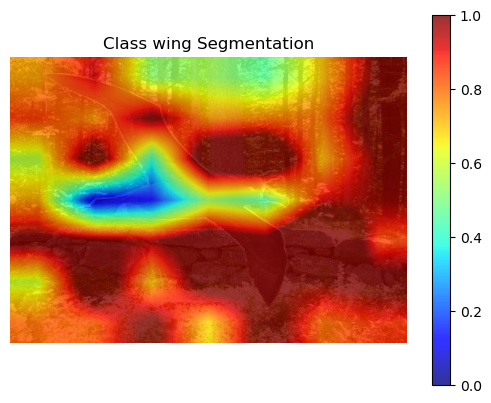

Layer 9


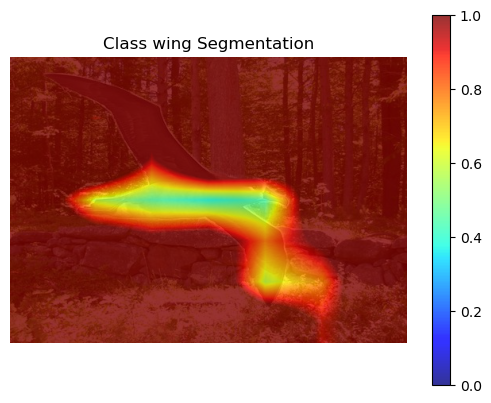

Layer 10


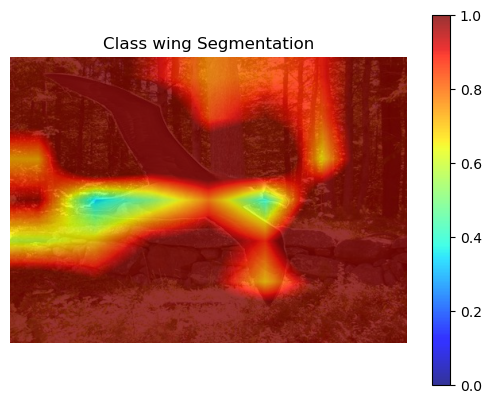

Layer 11


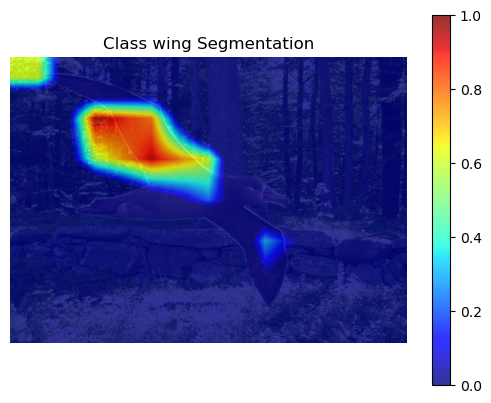

Final sum of all


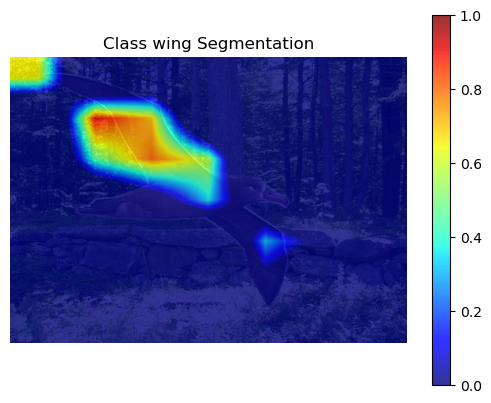


CHECK OTHER CONCEPTS

Layer 8


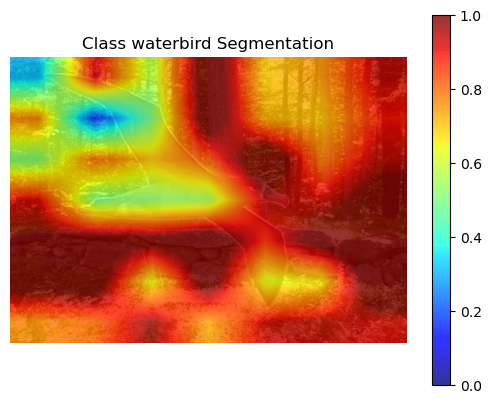

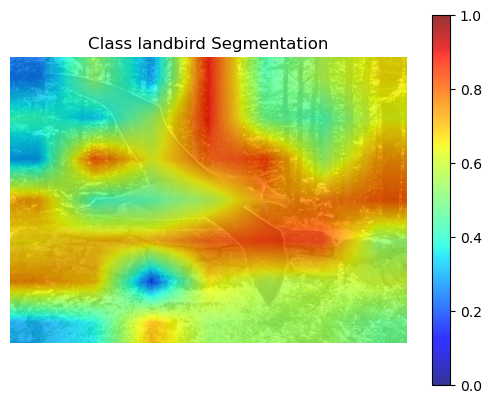

Layer 9


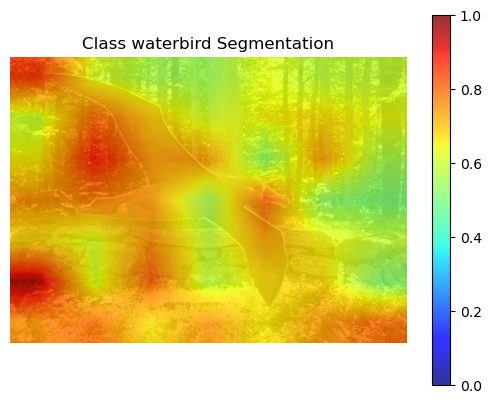

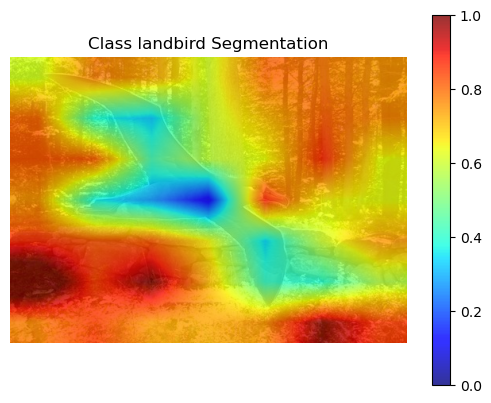

Layer 10


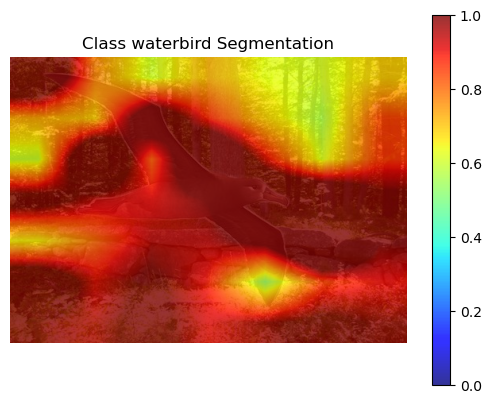

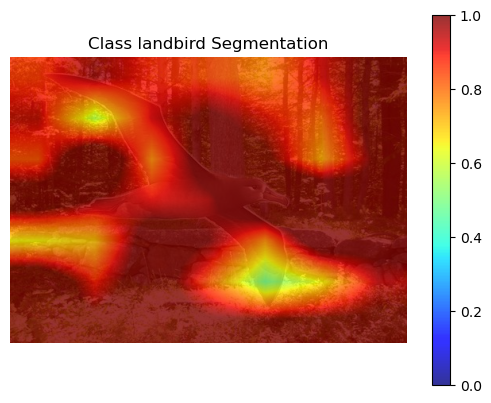

Layer 11


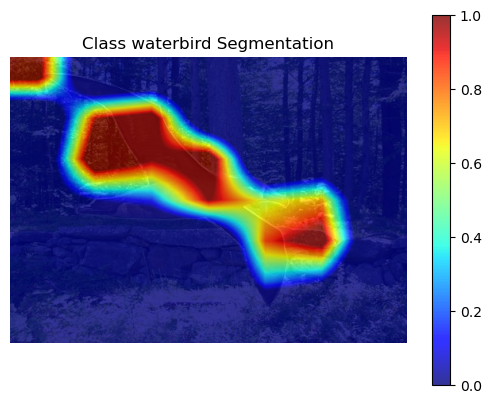

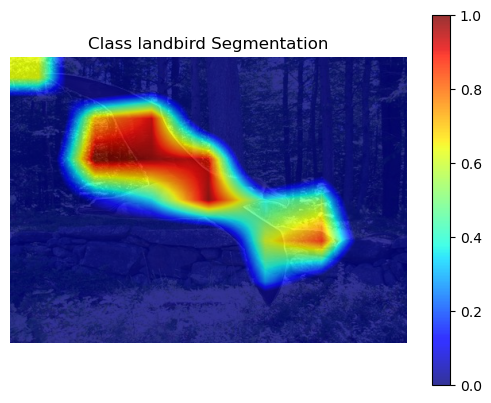

Final sum of all


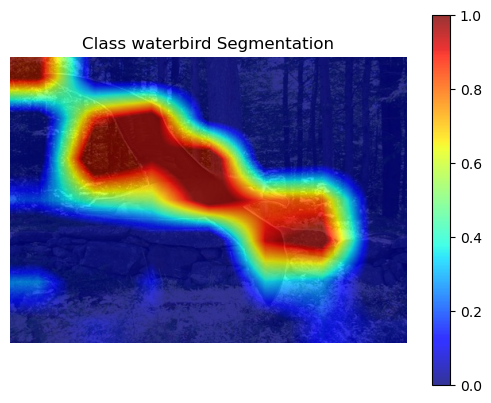

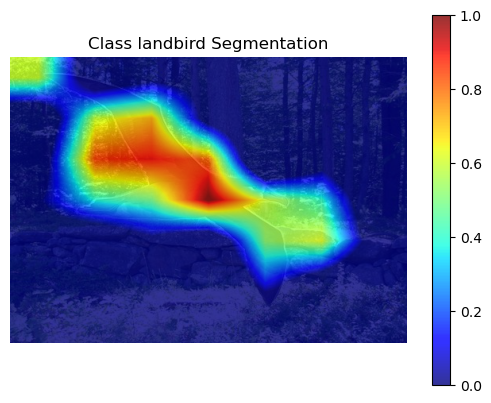

In [32]:
# Call the function early on to print the configuration summary.
data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)
# Decide where to look at
if look_at_pc:
    data = get_data_component(data, layer, head, pc)
elif look_at_head:
    data = get_data_head(data, layer, head)
# Whether to use the query system or not
elif query_system:
    # Patch model if needed
    mean_final_texts = torch.mean(final_embeddings_texts, axis=0)
    classes_centered = class_embeddings - mean_final_texts.unsqueeze(0)
    sorted_data = []
    for text_idx in range(classes_centered.shape[0]):
        # Perform query system on entry
        concept_i_centered = classes_centered[text_idx, :].unsqueeze(0)

        data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

        _, data_abs = reconstruct_embeddings(
            data, 
            [concept_i_centered], 
            ["text"], 
            return_princ_comp=True, 
            plot=False, 
            means=[mean_final_texts],
        )

        # Extract relevant details from the top k entries
        data_pcs = sort_data_by(data_abs, "correlation_princ_comp_abs", descending=True)
        top_k_entries = top_data(data_pcs, pcs_per_class)
             
        # Derive nr_pcs_per_class
        sorted_data += top_k_entries
        print(f"Currently processing label {lines[text_idx]} with nr_pcs_per_class: {pcs_per_class}")


    # Remove duplicates
    entries_set = []
    entries_meta = []
    for entry in sorted_data:
        layer = entry["layer"]
        head = entry["head"]
        princ_comp = entry["princ_comp"]
        if (layer, head, princ_comp) not in entries_meta:
            entries_meta.append((layer, head, princ_comp))
            entries_set.append(entry)

    if remove_concept:
        entries_set = get_remaining_pcs(data, entries_set)

    attentions_rec = reconstruct_all_embeddings_mean_ablation_pcs(
        entries_set,
        mlps,
        attentions,
        attns_,
        nr_layers_,
        nr_heads_,
        num_last_layers_,
        ratio=-1,
        mean_ablate_all=False, 
        return_attention=True
    )

else:
    entries_set = top_data(data, pcs_per_class)

    attentions_rec = reconstruct_all_embeddings_mean_ablation_pcs(
        entries_set,
        mlps,
        attentions,
        attns_,
        nr_layers_,
        nr_heads_,
        num_last_layers_,
        ratio=-1,
        mean_ablate_all=False, 
        return_attention=True
    )

# Plot different layers and the final aggregation contribution
for k in range(nr_layers_ - num_last_layers_plot, nr_layers_):
    print(f"Layer {k}")
    plot_segment_map(attentions_rec, class_embeddings, image_pil, lines, device, layer=k)
print("Final sum of all")
plot_segment_map(attentions_rec, class_embeddings, image_pil, lines, device)
# Check other concept if requested
if check_other_concept:
    print("\nCHECK OTHER CONCEPTS\n")
    ## Get the texts
    texts = tokenizer(other_concept).to(device)  # tokenize text for encoder
    class_embeddings_other = model.encode_text(texts)
    for k in range(nr_layers_ - num_last_layers_plot, nr_layers_):
        print(f"Layer {k}")
        plot_segment_map(attentions_rec, class_embeddings_other, image_pil, other_concept, device, layer=k)
    print("Final sum of all")
    plot_segment_map(attentions_rec, class_embeddings_other, image_pil, other_concept, device)
